# NLP Fake News
Mariano Giongrande - Comisión 61640

In [67]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [68]:
# Esta clase tiene los métodos que vinieron en el colab más métodos que desarrollé.

class ProcesadorNLP:

  def __init__(self):
    self.data = []

  def tomarMuestra(self,dataset, clase, nuevoTotal):
    total = dataset[clase].value_counts()
    muestrasPorClase = (total / total.sum() * nuevoTotal).astype(int)
    nuevoDf = dataset.groupby([clase], group_keys=False).apply(lambda x: x.sample(muestrasPorClase[x.name], random_state=42))

    return nuevoDf

  def preprocesarTexto(self,texto):
    """Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales."""
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]

    return " ".join(tokens)

  def graficarWordCloud(self,texto):
    texto_preprocesado = self.preprocesarTexto(texto)

    # Visualizar nube de palabras completando la secuencia de creaciòn
    text_combined = " ".join(texto_preprocesado)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_preprocesado)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Nube de palabras")
    plt.show()

  def generarCorpus(self,datasets):
    corpus = list()
    for dataset in datasets:
      corpus.append(self.preprocesarTexto(dataset))

    return corpus

  def graficarMatrizConfusion(self,categorias, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    pd_cm = pd.DataFrame(cm,index = categorias, columns=categorias)
    sns.heatmap(pd_cm, annot=True,fmt='d',cmap='crest',cbar=False)

  def getTopNgrams(self,corpus, n, top_k=10):
      vectorizer = CountVectorizer(ngram_range=(n, n))
      X = vectorizer.fit_transform(corpus)
      ngram_counts = X.sum(axis=0).A1
      ngram_features = vectorizer.get_feature_names_out()
      ngram_freq = list(zip(ngram_features, ngram_counts))
      ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
      return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

  def plotNgrams(self,ngram_df, title):
      plt.figure(figsize=(10, 5))
      sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
      plt.title(title)
      plt.xlabel("Frecuencia")
      plt.ylabel("N-gram")
      plt.show()

  def imprimirClasificationReport(self,y_test,y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [69]:
# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

In [70]:
# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

In [71]:
df.sentimiento.unique()

array(['FAKE', 'REAL'], dtype=object)

In [72]:
df = df.set_index('Unnamed: 0')

In [73]:
df.shape

(6335, 3)

In [74]:
df.head()

,title,texto,sentimiento
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [75]:
# Contar cuantas noticias reales y fakes hay en el dataset
# Està balanceado? Còmo lo arreglarìas sino?

df.sentimiento.value_counts()

,count
sentimiento,
REAL,3171
FAKE,3164


El dataset está balanceado.

In [76]:
# Dimensiona el dataset
# En tèrmino de variable que diferencias encuentras con los que usabas en Machine Learning?
df.shape

(6335, 3)

El dataset tiene 6335 registros y 4 columnas. Los datasets que utilizamos en Machine Learning tienen mayor cantidad de columnas, las cuales al final del preprocesamiento de los datos deben ser numéricas.

In [77]:
# Instancion el procesador

procesador = ProcesadorNLP()

In [78]:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
# Las clases quedaron balanceadas?


df2 = procesador.tomarMuestra(df,'sentimiento',3000)

<ipython-input-68-7ef94837c084>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nuevoDf = dataset.groupby([clase], group_keys=False).apply(lambda x: x.sample(muestrasPorClase[x.name], random_state=42))


In [79]:
df2.shape

(2999, 3)

In [80]:
df2.sentimiento.value_counts()

,count
sentimiento,
REAL,1501
FAKE,1498


In [81]:
# Ajustar etiquetas de sentimiento (0 = fake, 1 = real)

df2.sentimiento = df2.sentimiento.apply(lambda x: 1 if x == 'REAL' else 0)

In [82]:
df2.sentimiento.value_counts()

,count
sentimiento,
1,1501
0,1498


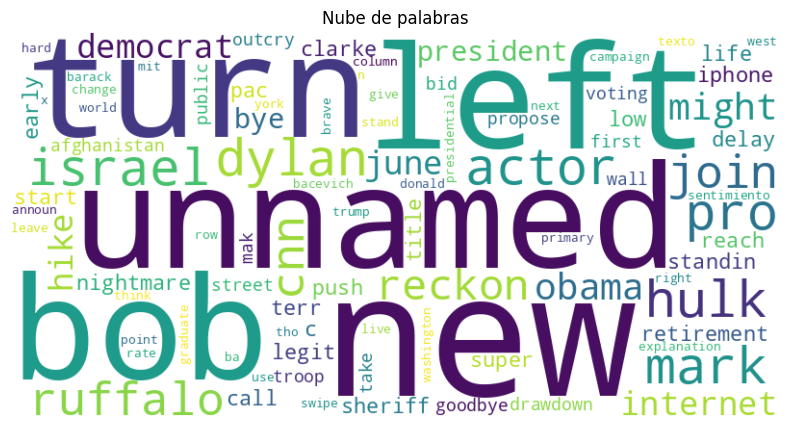

In [83]:
procesador.graficarWordCloud(df2)

In [84]:
df_real = df2.loc[df2.sentimiento == 1]

In [85]:
df_fake = df2.loc[df2.sentimiento == 0]

In [86]:
dfs = list()
dfs.append(df_real)
dfs.append(df_fake)

In [87]:
corpus = procesador.generarCorpus(dfs)

Unigramas más comunes:
    N-gram  Frecuencia
0    obama           5
1  clinton           4
2  hillary           4
3    trump           4
4  unnamed           4
5      cnn           3
6     mark           3
7      new           3
8    actor           2
9  america           2


<ipython-input-68-7ef94837c084>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


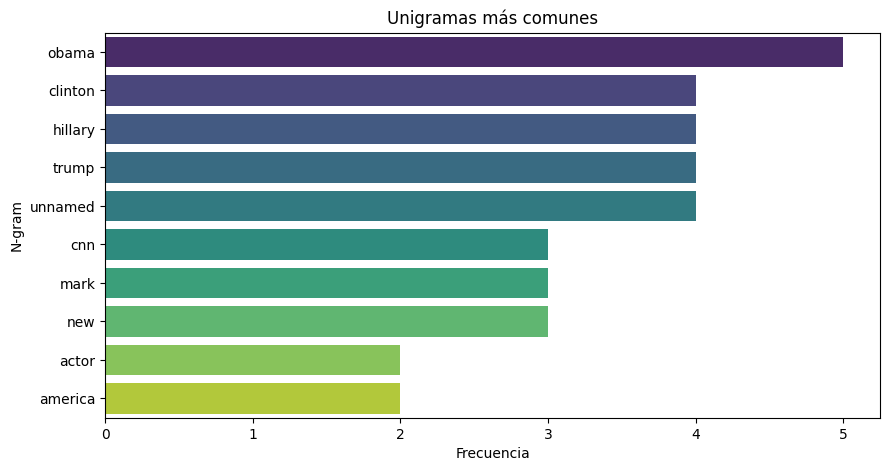


Bigramas más comunes:
              N-gram  Frecuencia
0    hillary clinton           3
1         actor mark           2
2          bob dylan           2
3  clinton introduce           2
4        debate feud           2
5          dylan pro           2
6           feud fox           2
7             fox ne           2
8         gop debate           2
9         hulk actor           2


<ipython-input-68-7ef94837c084>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


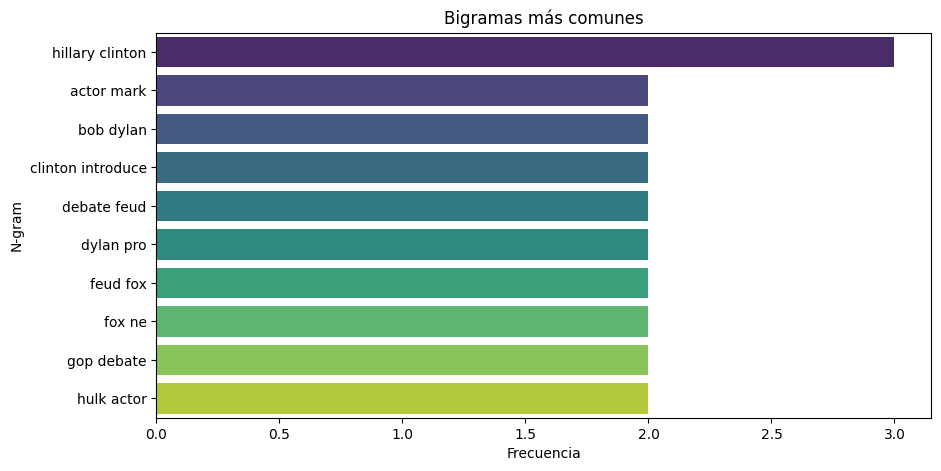


Trigramas más comunes:
                       N-gram  Frecuencia
0          actor mark ruffalo           2
1               bob dylan pro           2
2  clinton introduce michelle           2
3             debate feud fox           2
4            dylan pro israel           2
5                 feud fox ne           2
6             gop debate feud           2
7   hillary clinton introduce           2
8             hulk actor mark           2
9    introduce michelle obama           2


<ipython-input-68-7ef94837c084>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


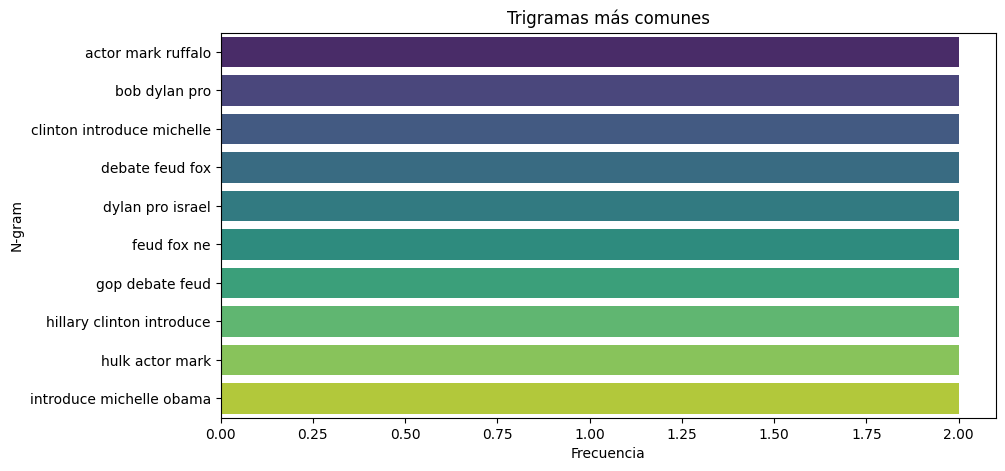


Cuatrigramas más comunes:
                               N-gram  Frecuencia
0             actor mark ruffalo join           2
1                bob dylan pro israel           2
2    clinton introduce michelle obama           2
3                  debate feud fox ne           2
4               dylan pro israel hulk           2
5                 gop debate feud fox           2
6  hillary clinton introduce michelle           2
7             hulk actor mark ruffalo           2
8              israel hulk actor mark           2
9                 left turn bob dylan           2


<ipython-input-68-7ef94837c084>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


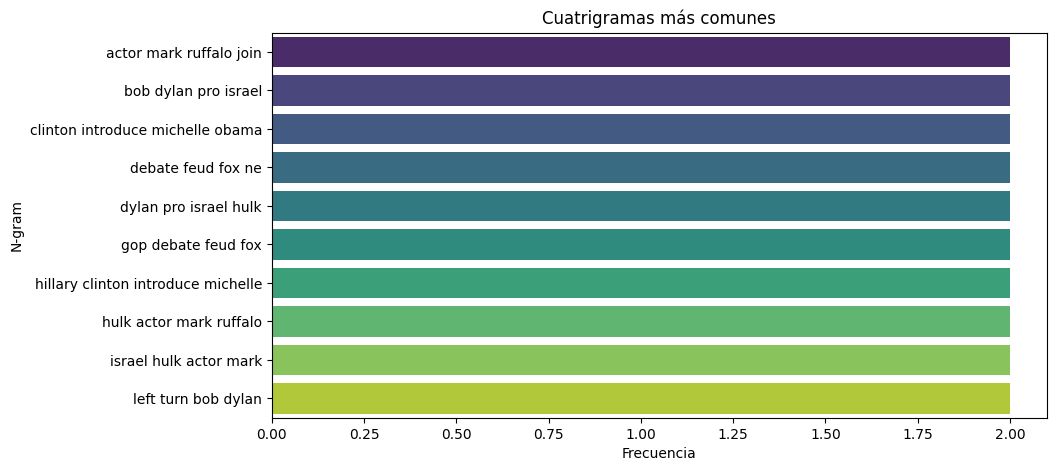

In [88]:
unigramas = procesador.getTopNgrams(corpus,1)
bigramas = procesador.getTopNgrams(corpus,2)
trigramas = procesador.getTopNgrams(corpus,3)
cuatrigramas = procesador.getTopNgrams(corpus,4)

print("Unigramas más comunes:")
print(unigramas)
procesador.plotNgrams(unigramas, "Unigramas más comunes")

print("\nBigramas más comunes:")
print(bigramas)
procesador.plotNgrams(bigramas, "Bigramas más comunes")

print("\nTrigramas más comunes:")
print(trigramas)
procesador.plotNgrams(trigramas, "Trigramas más comunes")

print("\nCuatrigramas más comunes:")
print(cuatrigramas)
procesador.plotNgrams(cuatrigramas, "Cuatrigramas más comunes")

In [89]:
# Separar datos en entrenamiento y prueba

df3 = df2.reset_index()[['title','texto','sentimiento']]
X = df3.drop(columns=['title','sentimiento']).values.ravel()
Y = df3.drop(columns=['title','texto']).values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [90]:
# Pipeline de vectorización y modelo

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [91]:
# Entrenar modelo

pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [92]:
# Predicciones
y_pred = pipeline.predict(X_test)

In [93]:
# Evaluación

procesador.imprimirClasificationReport(y_test,y_pred)

Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.99      0.49      0.66       315
           1       0.64      0.99      0.78       285

    accuracy                           0.73       600
   macro avg       0.81      0.74      0.72       600
weighted avg       0.82      0.73      0.71       600



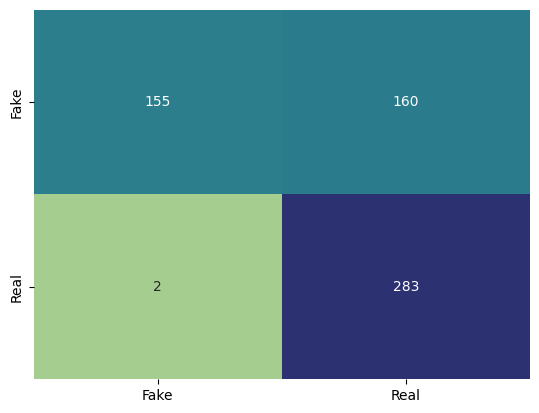

In [94]:
# Genero la matriz de confusión para mejor visualización de los resultados del modelo

categorias = ['Fake','Real']

procesador.graficarMatrizConfusion(categorias, y_test, y_pred)

 Este modelo tiene un accuracy global aceptable del 73%. Pero es para tener en cuenta el bajo recall de la clase FAKE ya que clasifica al 51% de los casos como REAL.
 Esto es un problema importante para este modelo, ya que buscamos identificar las noticias FAKE.

In [95]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [96]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [97]:
y_pred2=pac.predict(tfidf_test)

In [98]:
# Evaluación del nuevo modelo

procesador.imprimirClasificationReport(y_test, y_pred2)

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       315
           1       0.92      0.93      0.93       285

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



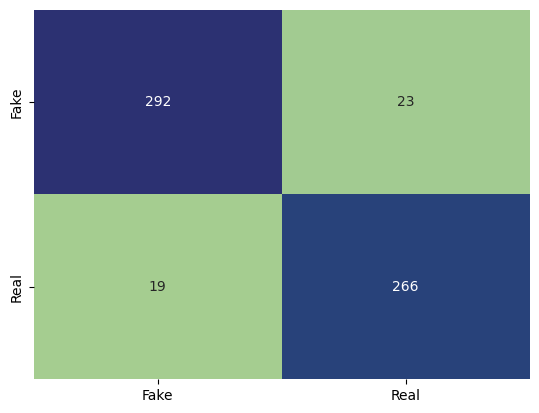

In [99]:
# Muestro la matriz de confusión para mejor visualización de los resultados del modelo

procesador.graficarMatrizConfusion(categorias, y_test, y_pred2)

Este modelo funciona mucho mejor aunque la clase REAL tenga un recall levemente menor que el modelo anterior.
Pero en este caso, la clase FAKE tiene un recall del 91%, por lo que está clasificando mucho mejor las noticias FAKE. De los 315 casos de noticias falsas, 286 fueron correctamente clasificadas.